In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from astropy.io.fits import getdata
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astropy.table import Table
from astroquery.xmatch import XMatch
import time
import pyvo as vo
#import sys  
#sys.path.insert(0, '/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/ML_pipelines_merge/MUWCLASS_pipeline_github/MUWCLASS/')
#from muwclass import datasets, prep, red,  classify, distribution, plots, prepare_data, prepare_cxo

from prepare_library import atnf_pos, create_perobs_data, cal_ave, add_MW, confusion_clean, TD_clean_vizier, Gaia_counterparts, CSC_clean_keepcols, vphasp_to_gaia_mags, Gaia_counterparts_update, create_field_csc_data, cal_PU, refsrc_gaia, cal_astrometric_correction

from test_library import prepare_cols

import warnings
warnings.filterwarnings('ignore') 

Vizier.ROW_LIMIT = -1
exnum = -999999.

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'
verb = 0

query_dir = '/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/TD/query/csc_query_cnt'

ref_obsID = 8941
ref_mjd = 5.4762887769419E+04
ra =166.28875
dec =  -58.85
radius = 25

In [3]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

field = SkyCoord(ra, dec, unit="deg") 
results = cone.search(pos=field, radius=radius * u.arcmin, verbosity=2)

df_res = results.to_table().to_pandas()

df_sig = df_res[df_res.significance>5].reset_index()
print(len(df_res), 'sources in total with', len(df_sig), 'sources significance>5.')
df_pers = create_perobs_data(df_sig, query_dir, data_dir, name_type='CSCview', name_col='name', ra_col='ra',dec_col='dec',coord_format='deg')
    
df_pers.to_csv(f'{data_dir}/{field_name}_per.csv', index=False)

412 sources in total with 145 sources significance>5.


In [19]:
#df = create_field_csc_data(data_dir, field_name,ra,dec,radius)

#df.to_csv(f'{data_dir}/{field_name}_per.csv', index=False)

In [20]:
#print(df)

df = cal_PU(df_pers, 'theta', 'src_cnts_aper90_b', 'PU_kim95', ver='kim95', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_csc90', ver='csc90', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_kim68', ver='kim68', sigma=1.)

df['PU_CSC'] = np.sqrt(df['err_ellipse_r0']**2 - 0.7**2)

df['RA'] = Angle(df['ra'], 'hourangle').degree
df['DEC'] = Angle(df['dec'], 'deg').degree

df.to_csv(f'{data_dir}/{field_name}_PU.csv', index=False)

In [21]:
df['per_remove_code'] = 0

df['usrid'] = df.index

df_ave, df_obs = cal_ave(df, data_dir, dtype='field',Chandratype='CSC',PU='PU_kim95',cnt=True,verb=verb)

df_ave = df_ave[df_ave['remove_code']==0].reset_index(drop=True)

df_ave.to_csv(f'{data_dir}/{field_name}_ave.csv', index=False)

Run cal_ave......
There are 145 per-obs data.
Run flux2symmetric......
Run flux2symmetric......
Run powlaw2symmetric......
Run apply_flags_filter......
After dropping 0 detections with HRC instrument, 145 remain.
After dropping 13 detections with theta larger than 10', 132 remain.
After dropping 0  detections with sat_src_flag = TRUE, 132 remain.
After dropping 0  detections with pile_warning>0.3, 132 remain.
After dropping 0  detections with streak_src_flag = TRUE, 132 remain.
After dropping 0  detections assigned to different sources, 132 remain.
Run cal_sig......
Run cal_aveflux......
Run cal_aveflux......
Run cal_var......
Run nan_flux......


In [4]:
#df_gaia = refsrc_gaia(field_name, data_dir, ref_mjd, ra=ra, dec=dec, R=12., exclude_center=False, Plx_limits=[-2.,2.], e_Plx_limit=1., e_PM_limit=1., PU_limits=1.)

df_gaia = refsrc_gaia(field_name, data_dir, ref_mjd, ra=ra, dec=dec, R=25., exclude_center=False, Plx_limits=[-2.,2.], e_Plx_limit=1., e_PM_limit=1., PU_limits=1., PM_limit=20, RUWE_limit=1.4)

The 90% percentile of epsi for NGC3532_02182022  field is  1.898 .


In [1]:
from ciao_library import Gaia_CSC_astro


data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'

for residlim in [0.1, 0.2, 0.3, 0.4]:

    Gaia_CSC_astro(field_name,data_dir,residlim=residlim,sig_astro=5,count_astro=20)

ModuleNotFoundError: No module named 'ciao_library'

In [3]:
from astropy.io import fits 
from prepare_library import  cal_astrometric_correction, cal_astro_pu, apply_astro_correct, MW_counterpart_confusion, counterpart_clean, CSC_clean
import pandas as pd
import numpy as np

data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'
sig_astro=5
count_astro=20
#ref_obsID = 8941
ref_mjd = 5.4762887769419E+04
#ra =166.28875
#dec =  -58.85
#radius = 25
cat = 'gaia'

    

residlims = [0.2]# [0.1, 0.2, 0.3, 0.4]
#residlims = [0.1, 0.2, 0.3, 0.4]
del_ras = []
del_decs = []
astro_pus, rms_ress, num_srcs = [], [], []
for residlim in residlims:

    del_ra, del_dec = cal_astrometric_correction(fits.open(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_xfm.fits'))#field_name,data_dir,residlim,sig_astro,count_astro)
    
    astro_pu, rms_res, num_src = cal_astro_pu(field_name,data_dir,residlim,sig_astro,count_astro)
    print(astro_pu, rms_res, num_src)
    
    del_ras.append(del_ra*3600)
    del_decs.append(del_dec*3600)
    astro_pus.append(astro_pu)
    rms_ress.append(rms_res)
    num_srcs.append(num_src)
    
    apply_astro_correct(field_name,data_dir,del_ra, del_dec, residlim,sig_astro,count_astro, astro_pu)
    
    df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_astro_correct.csv')
    ras = df['ra_cor'].values
    decs = df['dec_cor'].values
    Es = df['PU'].values
    search_radius, sig_nr = 300, 10 # arcsec
    df['_q'] = df.index+1
    
    for cat, confusion in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], [False]*6 ):
    
        df_MW = MW_counterpart_confusion(ras, decs, search_radius, Es=Es, N=sig_nr, catalog=cat,ref_mjd=ref_mjd,pm_cor=True,confusion=confusion)
        
        df_MW.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_{cat}.csv', index=False)

        df = pd.merge(df, df_MW, how='outer', on=['_q', '_q'])


        df = counterpart_clean(df, X_PU='PU', catalog=cat,X_mjd=ref_mjd,pu_factor=1.5,pm_cor=True,r2=True)
        #print(df.columns)
    
    #,'gaiadist'
    
    df.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_cp_clean.csv', index=False)
    df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_cp_clean.csv')
    df_MW_clean = CSC_clean_keepcols(df, withvphas=True)
    df_MW_clean = vphasp_to_gaia_mags(df_MW_clean)
    df_MW_clean.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_MW_clean.csv', index=False)
    
     

-0.47345818199705214 0.29802036015063194
The correction is 0.45" in ra and 0.15" in dec.
0.09236230984832164 0.125295 9
[0.19820128 0.10602348 0.12209043 0.15133265 0.15112671 0.07906629
 0.08753207 0.14375853 0.08683688]
cross-matching to gaia
cross-matching to gaiadist
102 MW counterparts remained for gaia
cross-matching to 2mass
84 MW counterparts remained for 2mass
cross-matching to catwise
52 MW counterparts remained for catwise
cross-matching to unwise
61 MW counterparts remained for unwise
cross-matching to allwise
38 MW counterparts remained for allwise
cross-matching to vphas
92 MW counterparts remained for vphas
132  sources in total.
remove_code = 1: CSC flags
10 sources with True  extent_flag
extent_flag [(False, 122), (True, 10)]
0 sources with True  pileup_flag
pileup_flag [(False, 132)]
0 sources with True  sat_src_flag
sat_src_flag [(False, 132)]
0 sources with True  streak_src_flag
streak_src_flag [(False, 132)]
16 sources with True  conf_flag
conf_flag [(False, 116), 

Text(0, 0.5, 'arcsec')

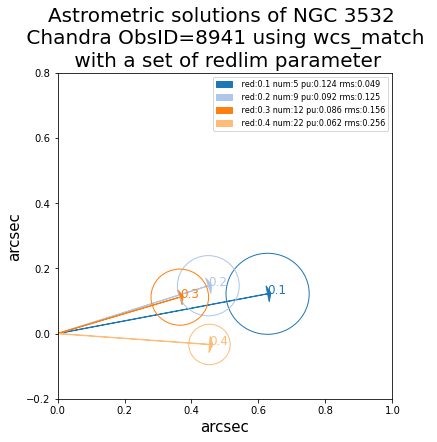

In [4]:
import matplotlib.pyplot as plt
#rho = 0.02182363072478699

fig, axs = plt.subplots(1,1, figsize=(6,6))
#axs = axs.flatten()
#for obsid, i, lims in zip(obsids, range(5), [[-1., 0.5 , -1, .5], [0, 1.5, -0.75, 0.75], [0, 1.5, -1.5, 0], [0, 2, -1, 1], [0, 2, 0, 2]]):
    
    #df_s = df[(df['obsid']==obsid)]
    
axs.set(xlim=(0, 1), ylim=(-0.2,0.8))

colors = iter([plt.cm.tab20(i) for i in range(20)])


x0, y0 = 0, 0 

del_ras, del_decs, rms_ress, residlims, astro_pus, num_srcs
    
for d_ra, d_dec, res, rms,pu, num,color in zip(del_ras, del_decs, residlims, rms_ress, astro_pus, num_srcs, colors):
    #p = (1.-np.exp(-rho*np.pi*res**2))*tot
    axs.arrow(x0, y0, d_ra, d_dec, head_width=0.05, head_length=0.01,fc=color,  ec=color,label=' red:'+str(res)+' num:'+str(num)+' pu:'+str(format(pu, '.3f'))+' rms:'+str(format(rms,'.3f')))
    circle = plt.Circle((d_ra, d_dec), pu, fc='none',ec=color, color = color, linewidth=1,alpha=1)
    axs.add_artist(circle)  
    axs.text(d_ra, d_dec,str(res),color=color,alpha=1.,fontsize=12)

axs.legend(fontsize=8)
axs.set_title('Astrometric solutions of NGC 3532 \n Chandra ObsID=8941 using wcs_match \n with a set of redlim parameter',fontsize=20)
axs.set_xlabel('arcsec',fontsize=15)
axs.set_ylabel('arcsec',fontsize=15)
#plt.show()
#plt.savefig('NGC3532_astro.eps')

In [5]:

# compare to previous and other resid results 

#df_pre = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/ML_pipelines_merge/MUWCLASS_pipeline_github/MUWCLASS_prepare_NGC3532/data/NGC3532_MW_clean.csv')

df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_MW_clean.csv')

for cat, iden in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], ['EDR3Name_gaia','_2MASS_2mass','objID_catwise','objID_unwise','AllWISE_allwise','sourceID_vphas']):
    
    df['flag_cp_compare_'+cat] = ''
    
    for res2 in [0.1, 0.3, 0.4]:
        df2 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res2}_5_20_MW_clean.csv')

        #df_compare = pd.merge(df[['name',iden,'cp_flag_'+cat]], df2[['name',iden,'cp_flag_'+cat]], on=['name','name'],how='inner')
        
        #df_dif = df_compare[((~df_compare[iden+'_x'].isnull()) | (~df_compare[iden+'_y'].isnull()))  & (df_compare[iden+'_x']!=df_compare[iden+'_y'])]
        
        df_com = df[['name',iden,'cp_flag_'+cat]].merge(df2[['name',iden,'cp_flag_'+cat]], how = 'inner' ,indicator=False)
        
        df.loc[~df.name.isin(df_com.name), 'flag_cp_compare_'+cat] = df.loc[~df.name.isin(df_com.name), 'flag_cp_compare_'+cat] + str(res2)[-1]
        
df.to_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv', index=False)


In [6]:
df_gaia = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')
#print(df_gaia.EDR3Name_gaia)
#df_gaia['Source_gaia'] = df_gaia.apply(lambda row: np.nan if pd.isnull(row.EDR3Name_gaia) else np.int64(row.EDR3Name_gaia[10:]), axis=1)
Gaia_counterparts(df_gaia,data_dir, field_name)
#print(df_gaia.Source_gaia)

INFO: Query finished. [astroquery.utils.tap.core]
(61540, 10)
132
132
(101, 13)
INFO: Query finished. [astroquery.utils.tap.core]
(11683, 19)
132
132
(34, 22)


In [7]:
df_gaia = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')

for cat in ['2mass', 'allwise']:
    df_MW = pd.read_csv(f'{data_dir}/{field_name}_'+cat+'_gaia.csv')
    df_MW = df_MW.add_suffix('_gaia')
    df_MW = df_MW.rename(columns= {'_q_gaia': '_q'} )
    df_gaia = pd.merge(df_gaia, df_MW, how='outer', on=['_q'])
    

for i in df.index:
    flags = []
    for cat,label in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], ['g','2','cw','uw','aw','v']):
        if pd.notna(df_gaia.loc[i,'flag_cp_compare_'+cat]) or ((df_gaia.loc[i, 'cp_flag_'+cat] <8) & (df_gaia.loc[i, 'cp_flag_'+cat] !=0)):
            flags.append(label)
        
    for cat,label in zip(['2mass_gaia','allwise_gaia'], ['2_g','aw_g']):
        if ((df_gaia.loc[i, 'cp_flag_'+cat] <8) & (df_gaia.loc[i, 'cp_flag_'+cat] !=0)):
            flags.append(label)
        
    df_gaia.loc[i,"cp_conf_flag"] = ",".join(flags)

df_gaia.to_csv(f'{data_dir}/{field_name}_MW_clean_update.csv',index=False)

In [3]:

df_MW_update = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')

df_save = prepare_cols(df_MW_update, cp_thres=-4, vphas=True,gaiadata=True)

['gaia', '2mass', 'catwise', 'unwise', 'allwise', 'vphas', '2mass_gaia', 'allwise_gaia']


In [4]:
df_save.to_csv('df_test.csv',index=False)

df_MW_update = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')
df_MW_update_sig = df_MW_update[df_MW_update.significance>5.]
df_MW_update_sig.sort_values(by='significance', ascending=False).to_csv(f'{data_dir}/{field_name}_MW_clean_update_sig.csv',index=False)

sig_astro=5
count_astro=20
cat = 'gaia'
data_dir = './data'
field_name = 'NGC3532'
residlims = [0.1, 0.2, 0.3, 0.4]
residlims_copy = residlims.copy()
for res1 in [0.1, 0.2, 0.3, 0.4]:
    
    df1 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res1}_{sig_astro}_{count_astro}_{cat}_clean.csv')
    residlims_copy.remove(res1)
    
    for res2 in residlims_copy:
        print(res1,'vs', res2)
        df2 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res2}_{sig_astro}_{count_astro}_{cat}_clean.csv')
    
        
        df_compare = pd.merge(df1[['name', 'EDR3Name_gaia']], df2[['name','EDR3Name_gaia']], on=['name','name'],how='inner')
        df_compare['EDR3Name_gaia_x'] = df_compare['EDR3Name_gaia_x'].str[10:]
        df_compare['EDR3Name_gaia_y'] = df_compare['EDR3Name_gaia_y'].str[10:]
        #print(df_compare)
    
        df_dif = df_compare[((~df_compare.EDR3Name_gaia_x.isnull()) | (~df_compare.EDR3Name_gaia_y.isnull()))  & (df_compare.EDR3Name_gaia_x!=df_compare.EDR3Name_gaia_y)]
        print(len(df_compare), len(df_dif), len(df_dif[df_dif.EDR3Name_gaia_x.isnull()]), len(df_dif[df_dif.EDR3Name_gaia_y.isnull()]))
        print(df_dif)
    
    
        